In [1]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt

In [2]:
def drawlines(img1,img2,lines,pts1,pts2):
    ''' img1 - image on which we draw the epilines for the points in img2
        lines - corresponding epilines '''
    r,c = img1.shape
    img1 = cv2.cvtColor(img1,cv2.COLOR_GRAY2BGR)
    img2 = cv2.cvtColor(img2,cv2.COLOR_GRAY2BGR)
    for r,pt1,pt2 in zip(lines,pts1,pts2):
        color = tuple(np.random.randint(0,255,3).tolist())
        x0,y0 = map(int, [0, -r[2]/r[1] ])
        x1,y1 = map(int, [c, -(r[2]+r[0]*c)/r[1] ])
        img1 = cv2.line(img1, (x0,y0), (x1,y1), color,2)
        img1 = cv2.circle(img1,tuple(pt1),5,color,-1)
        img2 = cv2.circle(img2,tuple(pt2),5,color,-1)
    return img1,img2

Text(0.5, 1.0, 'Image 2')

<Figure size 640x480 with 0 Axes>

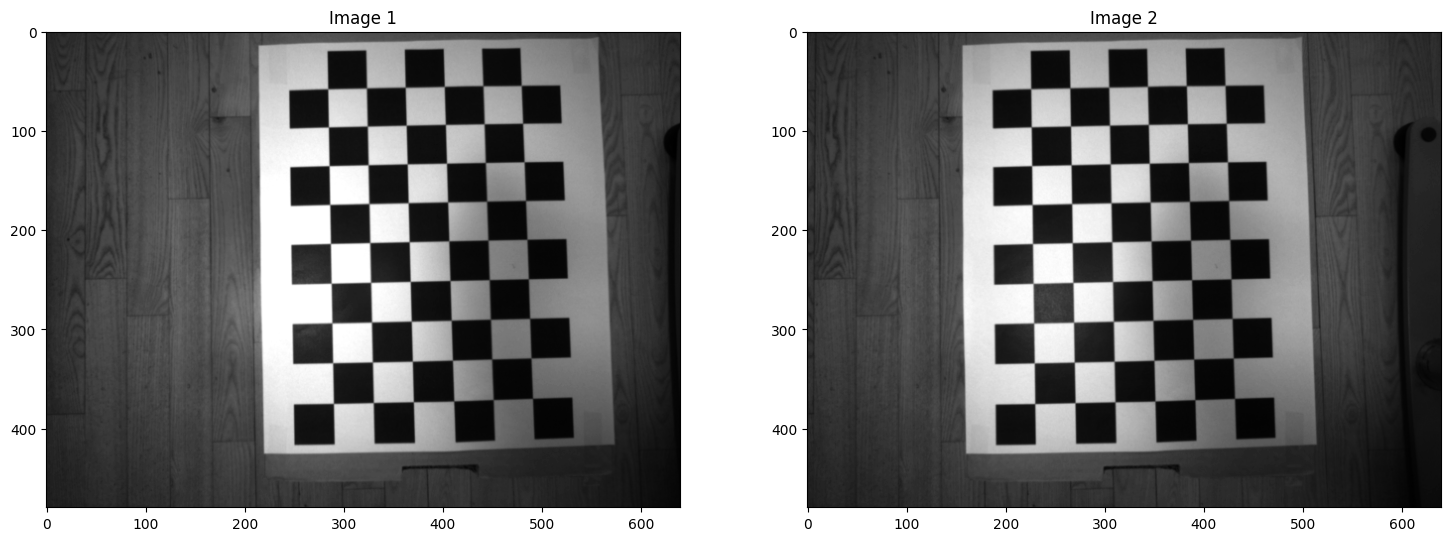

In [3]:
# LOAD IMAGES
img1 = cv2.imread('/home/hhauter/Documents/S23/Perception/34759-Perception-Exercises/Project_week_4/rs/left-0011.png')
img2 = cv2.imread('/home/hhauter/Documents/S23/Perception/34759-Perception-Exercises/Project_week_4/rs/right-0011.png')

img1 = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
img2 = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)

plt.gray()
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(18,18))
ax[0].imshow(img1)
ax[0].set_title('Image 1')
ax[1].imshow(img2)
ax[1].set_title('Image 2')


In [4]:
# UNDISTORD IMAGES
nb_vertical = 6
nb_horizontal = 9

# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((nb_horizontal*nb_vertical,3), np.float32)
objp[:,:2] = np.mgrid[0:nb_vertical,0:nb_horizontal].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d point in real world space
imgpoints_left = [] # 2d points in image plane.
imgpoints_right = [] # 2d points in image plane.

####################################### CAREFULL DEAR LINUX USERS ################################################
images_left = sorted(glob.glob('/home/hhauter/Documents/S23/Perception/34759-Perception-Exercises/Project_week_4/rs/left-*.png'))
images_right = sorted(glob.glob('/home/hhauter/Documents/S23/Perception/34759-Perception-Exercises/Project_week_4/rs/right-*.png'))
assert images_left
assert images_right


for fname in range(len(images_left)):
    img_left = cv2.imread(images_left[fname])
    gray_left = cv2.cvtColor(img_left, cv2.COLOR_BGR2GRAY)
    img_right = cv2.imread(images_right[fname])
    gray_right = cv2.cvtColor(img_right, cv2.COLOR_BGR2GRAY)
    ret, corners_left = cv2.findChessboardCorners(gray_left, (nb_vertical,nb_horizontal))
    ret, corners_right = cv2.findChessboardCorners(gray_right, (nb_vertical,nb_horizontal))

    # If found, add object points, image points (after refining them)
    if ret == True:
        objpoints.append(objp)

        imgpoints_left.append(corners_left)
        imgpoints_right.append(corners_right)

#         img = cv2.drawChessboardCorners(img_left, (nb_vertical,nb_horizontal), corners_left,ret)
#         cv2.imshow('img',img)
#         cv2.waitKey(500)

# cv2.destroyAllWindows()

In [5]:
ret, K_left, dist_left, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints_left, gray_left.shape[::-1], None, None)
ret, K_right, dist_right, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints_right, gray_right.shape[::-1], None, None)

h,  w = img1.shape[:2]
# K_left, roi = cv2.getOptimalNewCameraMatrix(mtx_left,dist_left,(w,h),1,(w,h))
# K_right, roi = cv2.getOptimalNewCameraMatrix(mtx_right,dist_right,(w,h),1,(w,h))




Text(0.5, 1.0, 'Undistorted image')

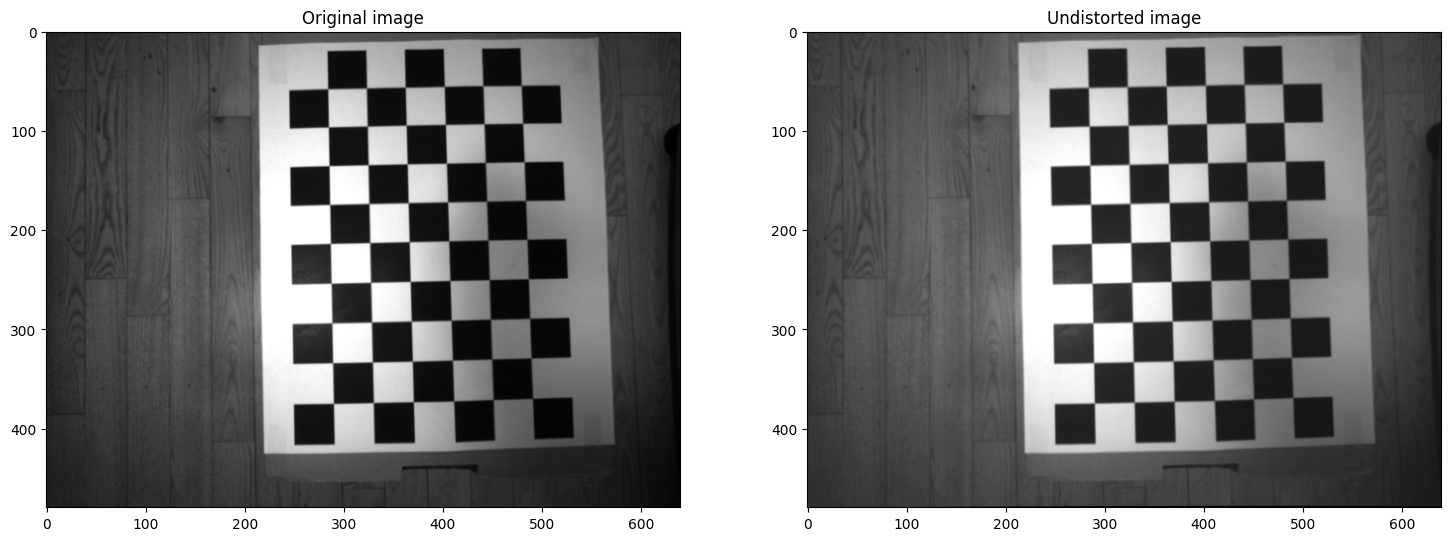

In [6]:
dst_left = cv2.undistort(img1, K_left, dist_left, None, K_left)
dst_right = cv2.undistort(img2, K_right, dist_left, None, K_left)
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(18,18))
ax[0].imshow(img1)
ax[0].set_title('Original image')
ax[1].imshow(dst_left)
ax[1].set_title('Undistorted image')

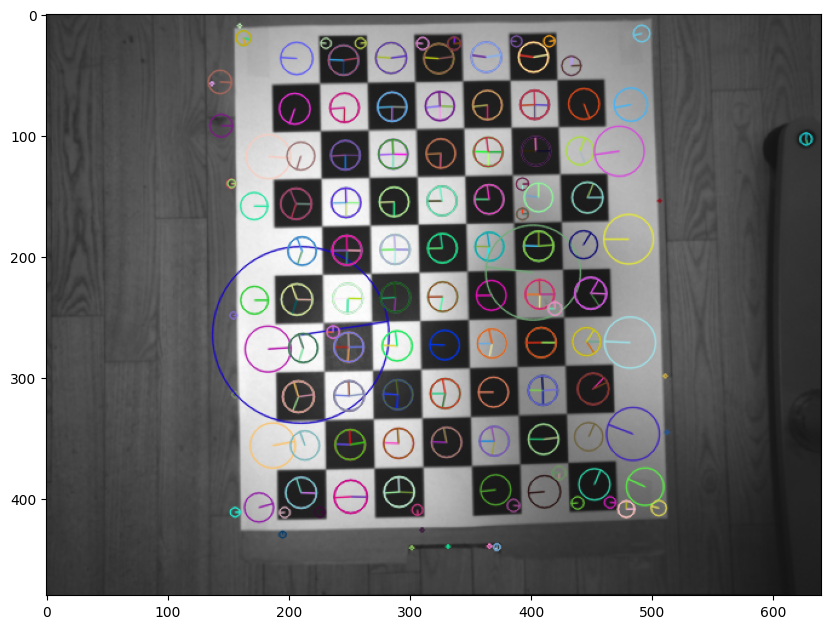

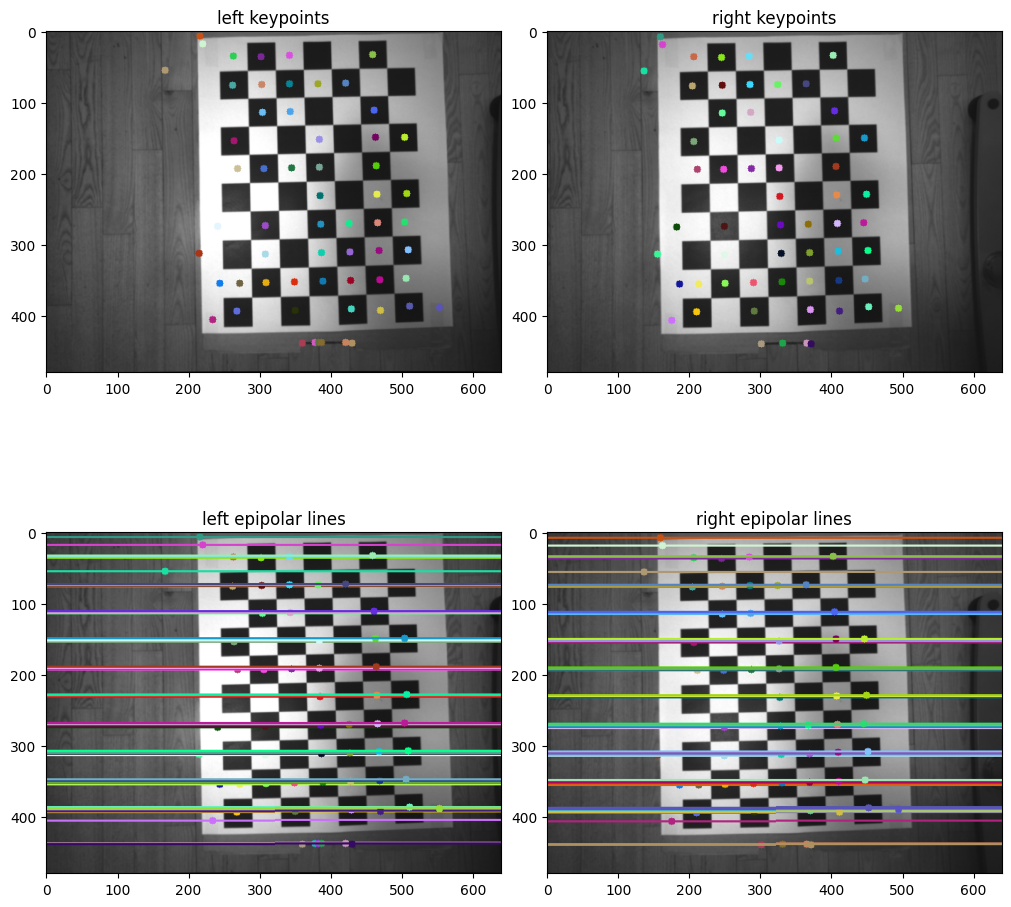

In [7]:
# DETECT KEYPOINTS: SIFT AND FLANN
sift = cv2.SIFT_create()
kp1, des1 = sift.detectAndCompute(dst_left, None)
kp2, des2 = sift.detectAndCompute(dst_right, None)

kp_img = cv2.drawKeypoints(dst_right, kp2, dst_right, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
plt.figure(figsize = (10,10))
plt.imshow(kp_img)

# FLANN parameters
FLANN_INDEX_KDTREE = 1
index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
search_params = dict(checks=50)
flann = cv2.FlannBasedMatcher(index_params,search_params)
matches = flann.knnMatch(des1,des2,k=2)
pts1 = []
pts2 = []
# ratio test as per Lowe's paper
for i,(m,n) in enumerate(matches):
    if m.distance < 0.8*n.distance:
        pts2.append(kp2[m.trainIdx].pt)
        pts1.append(kp1[m.queryIdx].pt)

pts1 = np.int32(pts1)
pts2 = np.int32(pts2)
F, mask = cv2.findFundamentalMat(pts1,pts2,cv2.FM_LMEDS)
# We select only inlier points
pts1 = pts1[mask.ravel()==1]
pts2 = pts2[mask.ravel()==1]

# Find epilines corresponding to points in right image (second image) and
# drawing its lines on left image
lines1 = cv2.computeCorrespondEpilines(pts2.reshape(-1, 1, 2), 2 ,F)
lines1 = lines1.reshape(-1, 3)
img5, img6 = drawlines(dst_left, dst_right, lines1, pts1, pts2)

# Find epilines corresponding to points in left image (first image) and
# drawing its lines on right image
lines2 = cv2.computeCorrespondEpilines(pts1.reshape(-1, 1, 2), 1, F)
lines2 = lines2.reshape(-1, 3)
img3, img4 = drawlines(dst_right, dst_left, lines2, pts2, pts1)

fig, axs = plt.subplots(2, 2, constrained_layout=True, figsize=(10,10))
axs[0, 0].imshow(img4)
axs[0, 0].set_title('left keypoints')
axs[0, 1].imshow(img6)
axs[0, 1].set_title('right keypoints')
axs[1, 0].imshow(img5)
axs[1, 0].set_title('left epipolar lines')
axs[1, 1].imshow(img3)
axs[1, 1].set_title('right epipolar lines')
plt.show()

In [8]:
# GET ROTATION AND TRANSLATION (as well as fundamental and essential matrix)
imgpoints_left = np.array(imgpoints_left, dtype=np.float32)
imgpoints_right = np.array(imgpoints_right, dtype=np.float32)
objpoints = np.array(objpoints, dtype=np.float32)
ret, K1, D1, K2, D2, R, T, E, F = cv2.stereoCalibrate(objpoints, imgpoints_left, imgpoints_right, K_left, dist_left, K_right, dist_right, gray_left.shape[::-1], cv2.CALIB_FIX_INTRINSIC)
print(ret)

0.3202261728036253


In [9]:
# RECTIFY 
R1, R2, P1, P2, Q, roi_left, roi_right = cv2.stereoRectify(K_left, dist_left, K_right, dist_right, gray_left.shape[::-1], R, T, flags=cv2.CALIB_ZERO_DISPARITY, alpha=0)

In [10]:
map1_left, map2_left = cv2.initUndistortRectifyMap(K1, D1, R1, P1, gray_left.shape[::-1],  cv2.CV_32FC1)
map1_right, map2_right = cv2.initUndistortRectifyMap(K2, D2, R2, P2, gray_right.shape[::-1],  cv2.CV_32FC1)

left_rectified = cv2.remap(img1, map1_left, map2_left, cv2.INTER_LINEAR)
right_recified = cv2.remap(img2, map1_right, map2_right, cv2.INTER_LINEAR)


Text(0.5, 1.0, 'Rectivied Image 2')

<Figure size 640x480 with 0 Axes>

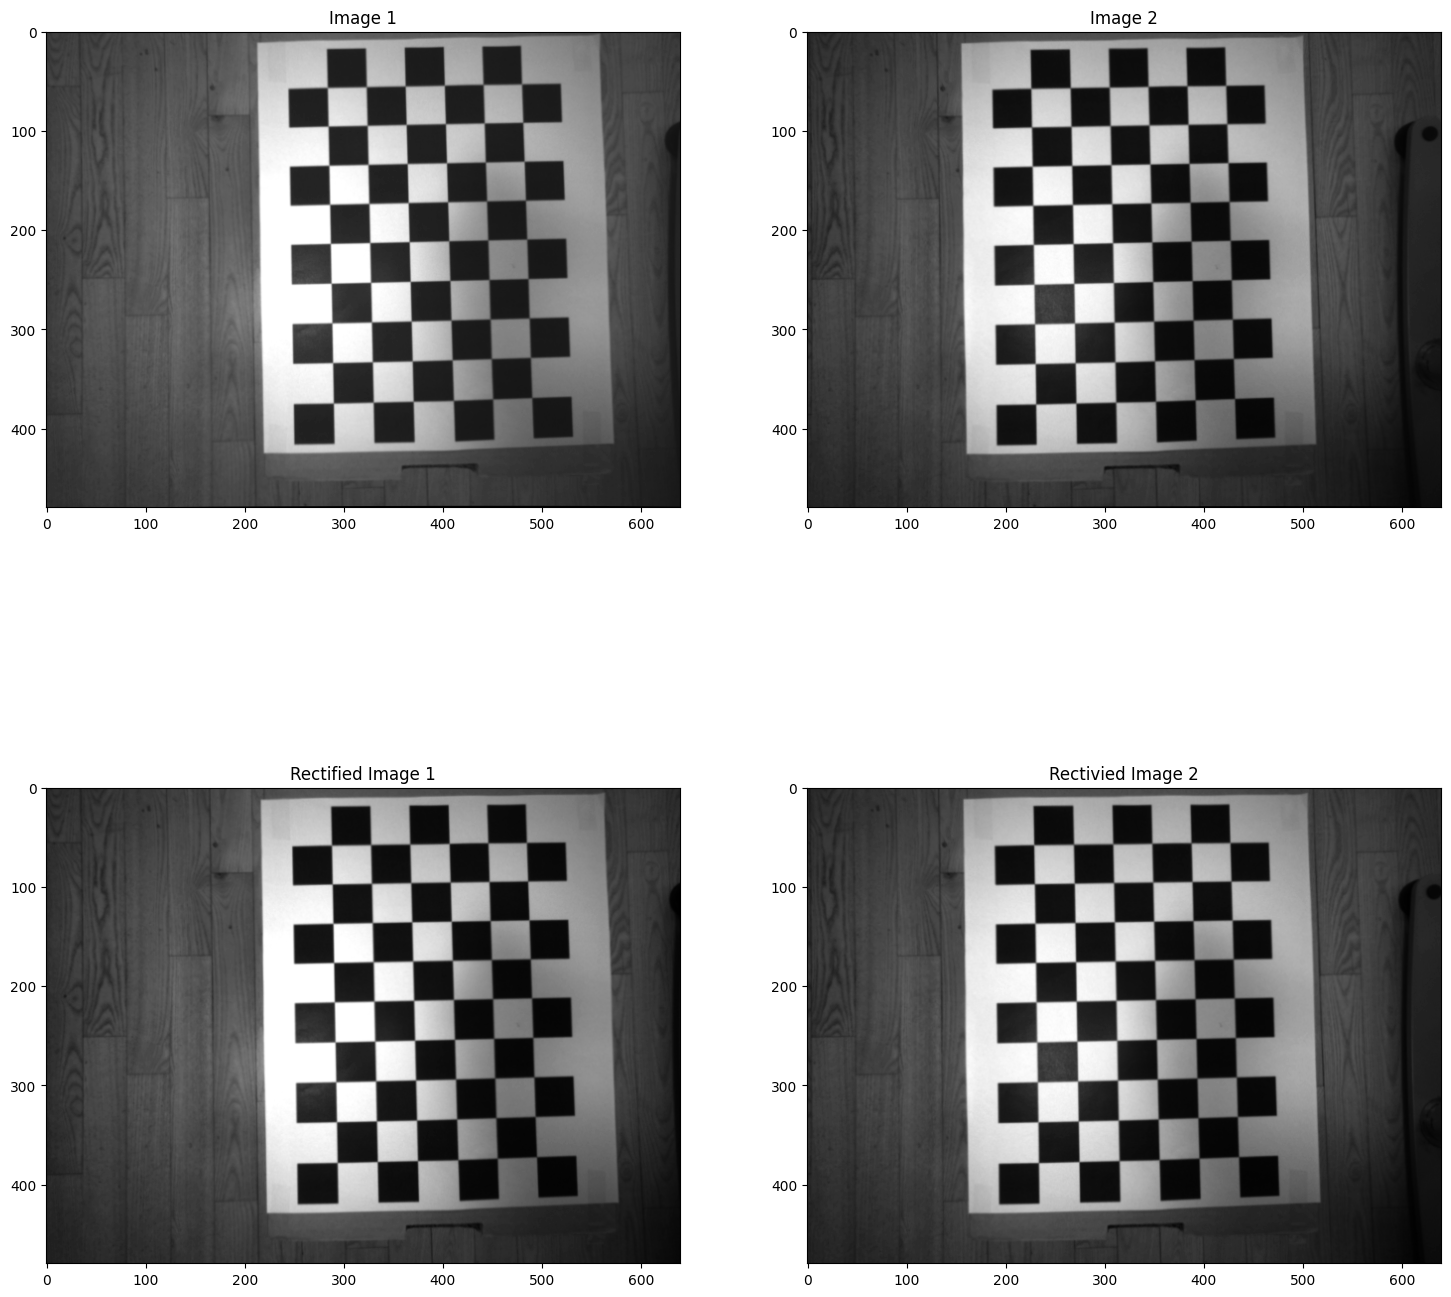

In [11]:
plt.gray()
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(18,18))
ax[0,0].imshow(dst_left)
ax[0,0].set_title('Image 1')
ax[0,1].imshow(dst_right)
ax[0,1].set_title('Image 2')
ax[1,0].imshow(left_rectified)
ax[1,0].set_title('Rectified Image 1')
ax[1,1].imshow(right_recified)
ax[1,1].set_title('Rectivied Image 2')




(480, 640)
(480, 1280)


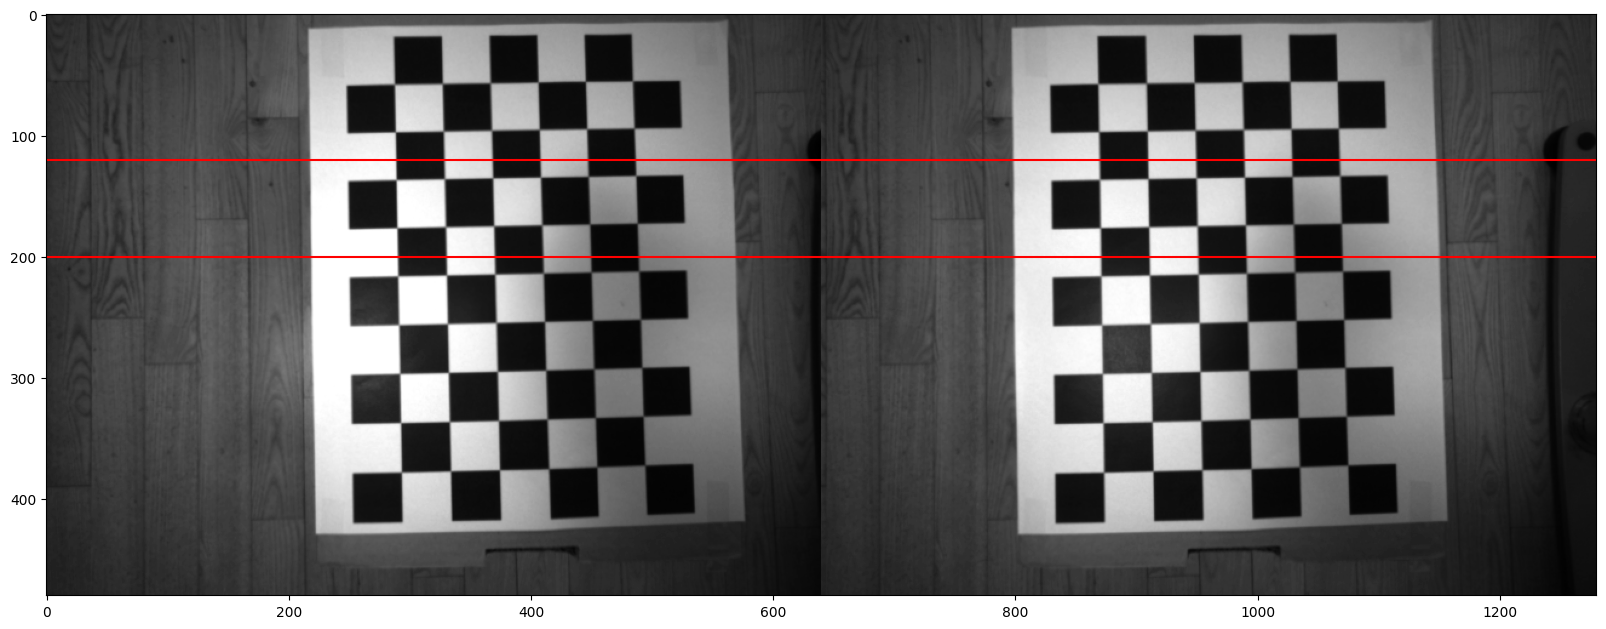

In [12]:
imgs_comb = np.hstack([left_rectified, right_recified])
print(dst_left.shape)
print(imgs_comb.shape)
plt.figure(figsize=(20,12))
plt.axhline(120, color='r') # horizontal
plt.axhline(200, color='r') # horizontal
plt.imshow(imgs_comb)
plt.show()

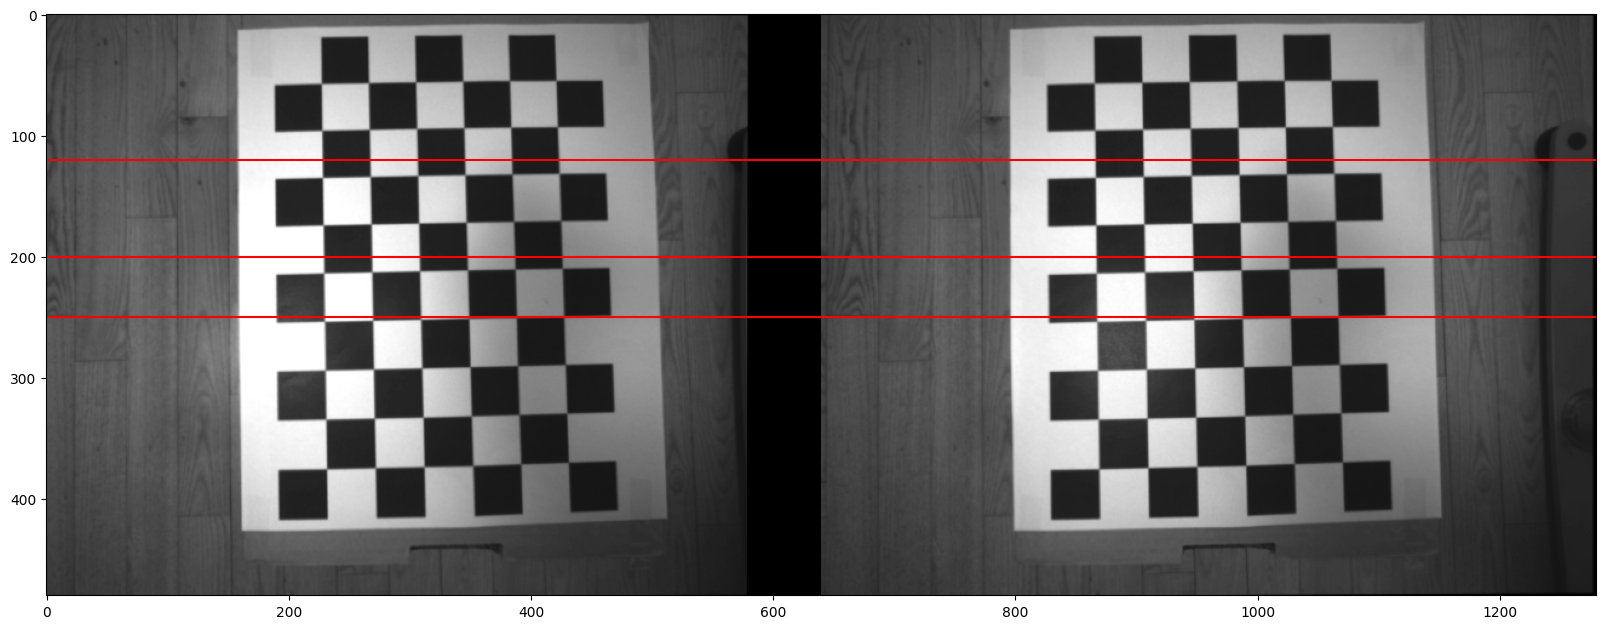

In [13]:
h1, w1 = img1.shape
h2, w2 = img2.shape
_, H1, H2 = cv2.stereoRectifyUncalibrated(
    np.float32(pts1), np.float32(pts2), F, imgSize=(w1, h1)
)
img1_rectified = cv2.warpPerspective(img1, H1, (w1, h1))
img2_rectified = cv2.warpPerspective(img2, H2, (w2, h2))
imgs_comb_new = np.hstack([img1_rectified, img2_rectified])

plt.figure(figsize=(20,12))
plt.axhline(120, color='r') # horizontal
plt.axhline(200, color='r') # horizontal
plt.axhline(250, color='r') # horizontal
plt.imshow(imgs_comb_new)
plt.show()


In [1]:
# E = K_right.T @ F @ K_left
# _, R, t = cv2.decomposeEssentialMat(E)

# shp = (dst_left.shape[1], dst_left.shape[0])
# R1, R2, P1, P2, Q, _, _ = cv2.stereoRectify(K_left, dist_left, K_right, dist_right,
#                                              shp, R, t, alpha=0)

# # Apply the rectification transformation to the images
# mapx_left, mapy_left = cv2.initUndistortRectifyMap(K_left, dist_left, R1, P1, shp, cv2.CV_32FC1)
# mapx_right, mapy_right = cv2.initUndistortRectifyMap(K_right, dist_right, R2, P2, shp, cv2.CV_32FC1)
# left_rectified = cv2.remap(dst_left, mapx_left, mapy_left, cv2.INTER_LINEAR)
# right_rectified = cv2.remap(dst_right, mapx_right, mapy_right, cv2.INTER_LINEAR)

# imgs_comb = np.hstack([left_rectified, right_recified])
# print(dst_left.shape)
# print(imgs_comb.shape)
# plt.figure(figsize=(20,12))
# plt.axhline(120, color='r') # horizontal
# plt.axhline(200, color='r') # horizontal
# plt.imshow(imgs_comb)
# plt.show()